# RESNET 50 with virus/bacterial classifier
source: https://www.kaggle.com/natevegh/pneumonia-detection-98-acc-fastai-2019-update

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
from fastai.metrics import error_rate
import os

In [3]:
import fastai_addons   #add plot2 extension -- learn.recorder.plot2()
from fastai_addons import interpretation_summary, plot_confusion_matrix, get_accuracy, \
                          analyze_confidence, accuracy_vs_threshold, show_incremental_accuracy, \
                          analyze_low_confidence, plot_confusion_matrix_thresh

In [4]:
model = models.resnet50
prefix = 'resnet50_classifier_'
size=900
bs = 10

In [5]:
path = Path()/'data'/'chest_xray'
path.ls()

[WindowsPath('data/chest_xray/data'),
 WindowsPath('data/chest_xray/test'),
 WindowsPath('data/chest_xray/train'),
 WindowsPath('data/chest_xray/val')]

In [6]:
def get_databunch(path, bs=8, size=500, workers=1, valid_pct=0.2, seed=None, tfms=None):
    if tfms is None:
        tfms = get_transforms()
        
    def filter_files(file_path, selected=('bacteria', 'virus')):
        base = file_path.stem
        for s in selected:
            if s in base:
                return True
        return False
        
    def get_labels(file_path, known_classes=('normal', 'bacteria', 'virus'), default='normal'): 
        base = file_path.stem
        for k in known_classes:
            if k in base:
                return k
        return default

    il = ImageList.from_folder(path).filter_by_func(filter_files).split_by_rand_pct(valid_pct).label_from_func(get_labels).transform(tfms, size=size)
    db = il.databunch(bs=bs, num_workers=workers).normalize(imagenet_stats)
    return db

In [7]:
data = get_databunch(path / 'train', bs=bs, size=size, workers=7)
data

ImageDataBunch;

Train: LabelList (3100 items)
x: ImageList
Image (3, 900, 900),Image (3, 900, 900),Image (3, 900, 900),Image (3, 900, 900),Image (3, 900, 900)
y: CategoryList
bacteria,virus,bacteria,bacteria,bacteria
Path: data\chest_xray\train;

Valid: LabelList (775 items)
x: ImageList
Image (3, 900, 900),Image (3, 900, 900),Image (3, 900, 900),Image (3, 900, 900),Image (3, 900, 900)
y: CategoryList
virus,bacteria,bacteria,bacteria,bacteria
Path: data\chest_xray\train;

Test: None

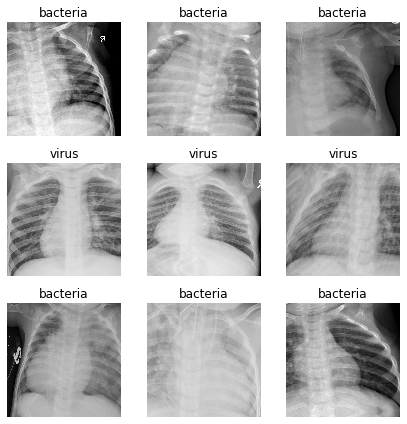

In [8]:
data.show_batch(3, figsize=(6,6))

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['bacteria', 'virus'], 2, 3100, 775)

## Train Classifier

In [21]:
learn = cnn_learner(data, model, metrics=error_rate, 
                    model_dir=(path/'models')).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06 
Min loss divided by 10: 1.32E-03
Min numerical gradient: 6.31E-07  (smoothed)
Min numerical gradient: 1.91E-06
Min loss divided by 10: 1.58E-03


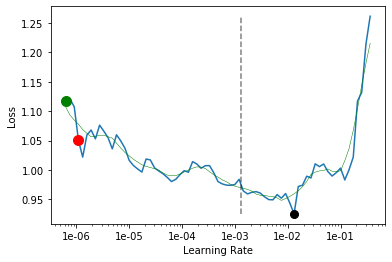

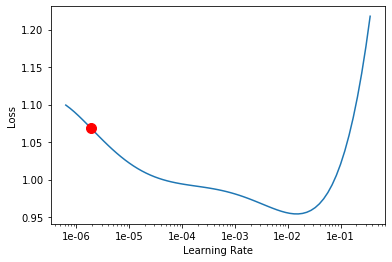

In [22]:
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

In [23]:
learn.fit_one_cycle(8, max_lr=3e-3)  #   0.490089	0.511407	0.259355
learn.fit_one_cycle(16, max_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.700424,0.608855,0.277419,02:49
1,0.593414,0.575075,0.282581,02:49
2,0.612394,0.576652,0.281290,02:50
3,0.601460,0.562223,0.299355,02:49
4,0.571787,0.556563,0.265806,02:49
5,0.547165,0.536931,0.274839,02:50
6,0.511219,0.523211,0.261935,02:50
7,0.504033,0.516002,0.259355,02:52


epoch,train_loss,valid_loss,error_rate,time
0,0.493702,0.518776,0.261935,02:53
1,0.530263,0.513236,0.264516,02:50
2,0.478857,0.509424,0.255484,02:49
3,0.497232,0.520176,0.260645,02:50
4,0.497423,0.516909,0.263226,02:49
5,0.452726,0.541009,0.264516,02:48
6,0.503018,0.503527,0.255484,02:53
7,0.465247,0.527693,0.233548,02:51
8,0.472849,0.498051,0.237419,02:51
9,0.442799,0.506348,0.237419,02:49


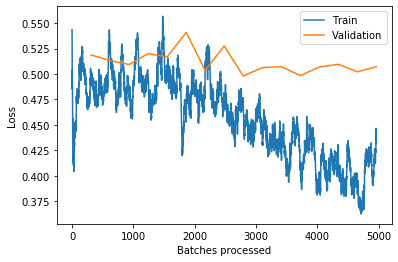

In [24]:
learn.recorder.plot_losses()

In [25]:
learn.save(prefix+'stage-1')

In [26]:
learn.fit_one_cycle(16, max_lr=3e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.357042,0.504895,0.224516,02:50
1,0.417399,0.505894,0.232258,02:48
2,0.396340,0.505657,0.228387,02:50
3,0.434354,0.516890,0.240000,02:49
4,0.399816,0.511046,0.232258,02:49
5,0.365714,0.518375,0.241290,02:49
6,0.367530,0.514203,0.241290,02:49
7,0.392408,0.505226,0.241290,02:49
8,0.381396,0.527954,0.232258,02:48
9,0.388389,0.510613,0.236129,02:48


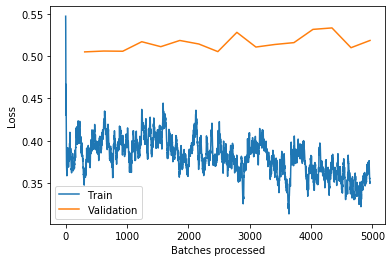

In [27]:
learn.recorder.plot_losses()

In [28]:
learn.save(prefix+'stage-a1')

In [29]:
learn.fit_one_cycle(16, max_lr=1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.374858,0.510821,0.230968,02:50
1,0.369010,0.513065,0.233548,02:48
2,0.371105,0.525503,0.228387,02:49
3,0.405263,0.515257,0.228387,02:52
4,0.385577,0.520107,0.230968,02:49
5,0.349801,0.512643,0.237419,02:49
6,0.364727,0.510665,0.228387,02:49
7,0.364922,0.514411,0.234839,02:49
8,0.372286,0.518527,0.228387,02:49
9,0.375339,0.513075,0.229677,02:49


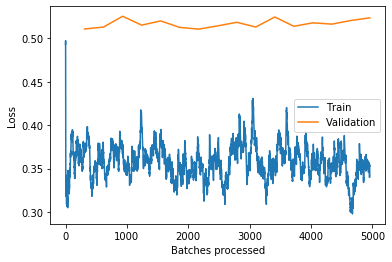

In [30]:
learn.recorder.plot_losses()

In [31]:
learn.save(prefix+'stage-1b')

In [32]:
learn.fit_one_cycle(16, max_lr=3e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.350353,0.524629,0.242581,02:49
1,0.339538,0.512813,0.228387,02:48
2,0.338225,0.527947,0.225806,02:48
3,0.360324,0.523281,0.230968,02:49
4,0.373966,0.535278,0.229677,02:48
5,0.341487,0.534136,0.227097,02:48
6,0.349656,0.526719,0.221935,02:49
7,0.364185,0.519136,0.243871,02:49
8,0.335480,0.520093,0.230968,02:48
9,0.344618,0.517107,0.238710,02:48


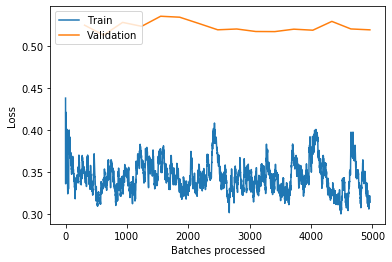

In [33]:
learn.recorder.plot_losses()

In [34]:
learn.save(prefix+'stage-1c')

In [35]:
learn.fit_one_cycle(16, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.351164,0.523892,0.224516,02:48
1,0.337013,0.524185,0.234839,02:48
2,0.360863,0.516601,0.228387,02:49
3,0.336842,0.522001,0.225806,02:48
4,0.319766,0.522585,0.232258,02:48
5,0.332021,0.515654,0.227097,02:49
6,0.339114,0.524598,0.227097,02:49
7,0.355164,0.521317,0.233548,02:48
8,0.328626,0.515509,0.225806,02:48
9,0.336044,0.520733,0.230968,02:49


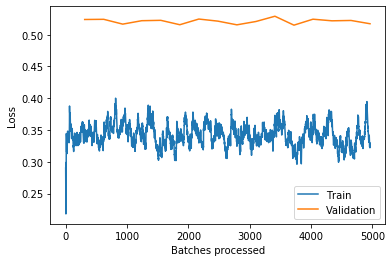

In [36]:
learn.recorder.plot_losses()

In [37]:
learn.save(prefix+'stage-1d')

### Most of the additional training appears top be overfitting

## Fine Tune

In [38]:
learn.load(prefix+'stage-1')
save_name = prefix+'stage-2'
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06 
Min loss divided by 10: 5.25E-06
Min numerical gradient: 1.91E-06  (smoothed)
Min numerical gradient: 4.79E-06
Min loss divided by 10: 2.51E-06


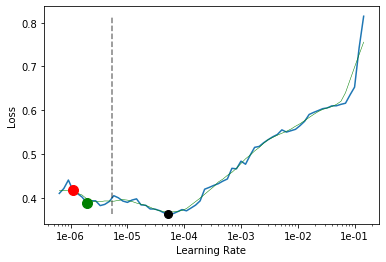

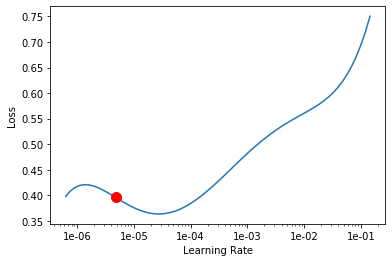

In [39]:
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

In [41]:
learn.fit_one_cycle(8, max_lr=slice(1e-7, 1e-5),
                    callbacks=[SaveModelCallback(learn, every='improvement', name=save_name)])

epoch,train_loss,valid_loss,error_rate,time
0,0.408344,0.505856,0.229677,03:08
1,0.393322,0.511417,0.236129,03:12
2,0.385198,0.500905,0.227097,03:12
3,0.405693,0.499744,0.228387,03:13
4,0.415741,0.505171,0.233548,03:14
5,0.413133,0.504508,0.228387,03:14
6,0.394586,0.494922,0.221935,03:14
7,0.415704,0.498925,0.228387,03:14


Better model found at epoch 0 with valid_loss value: 0.5058555006980896.
Better model found at epoch 2 with valid_loss value: 0.5009050965309143.
Better model found at epoch 3 with valid_loss value: 0.49974408745765686.
Better model found at epoch 6 with valid_loss value: 0.4949221611022949.


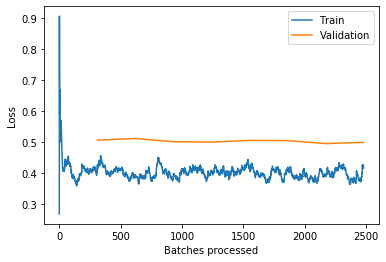

In [42]:
learn.recorder.plot_losses()

## Look At Results

In [43]:
interp = ClassificationInterpretation.from_learner(learn)

            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        82%         84%        67%        0.83
virus           70%         67%        84%        0.68


Overall Accuracy: 77.81%


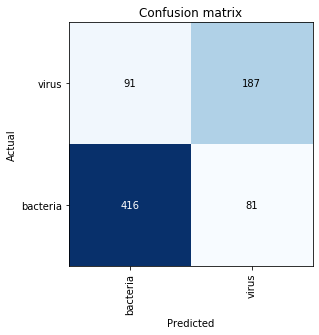

In [147]:
plot_confusion_matrix(interp)
interpretation_summary(interp)

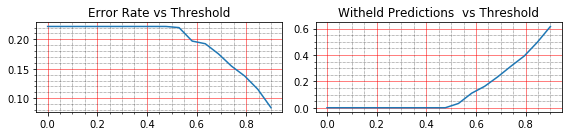

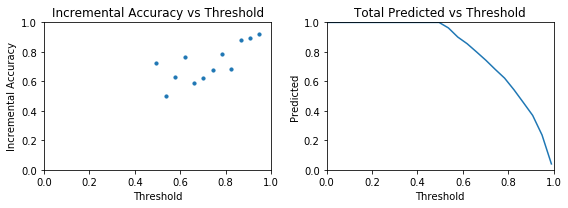

In [148]:
accuracy_vs_threshold(interp)
show_incremental_accuracy(interp)

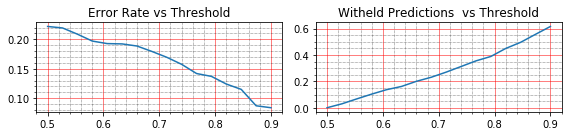

In [149]:
accuracy_vs_threshold(interp, threshold_range=(0.5, 0.9, 4*4))

            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        86%         90%        67%        0.88
virus           75%         67%        90%        0.71


Overall Accuracy: 82.76%
Accuracy: 82.76%   Error: 17.24%   Unknown: 25.16%   @ Threshold: 0.70

Confidence Histograms @ t=0.7


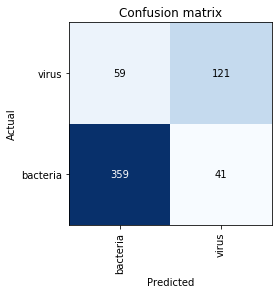

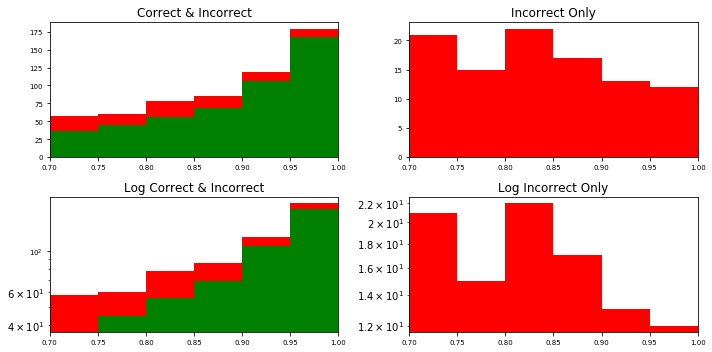

In [150]:
interpretation_summary(interp, thresh=0.7)
plot_confusion_matrix_thresh(interp, thresh=0.7)
analyze_confidence(interp, thresh=0.7)

            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        91%         95%        72%        0.93
virus           82%         72%        95%        0.76


Overall Accuracy: 89.06%
Accuracy: 89.06%   Error: 10.94%   Unknown: 50.45%   @ Threshold: 0.85

Confidence Histograms @ t=0.85


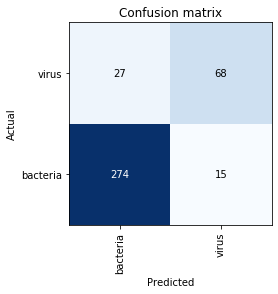

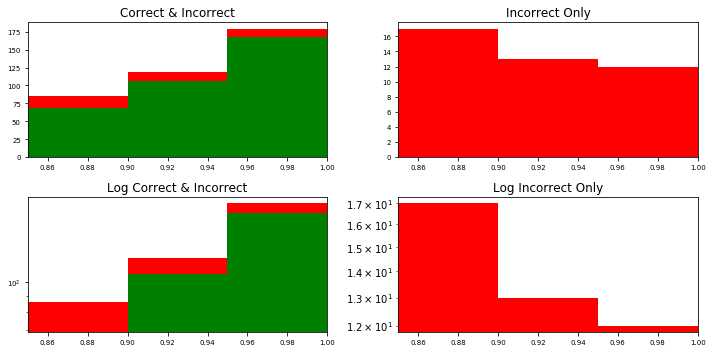

In [151]:
interpretation_summary(interp, thresh=0.85)
plot_confusion_matrix_thresh(interp, thresh=0.85)
analyze_confidence(interp, thresh=0.85)